## PyTorch

### CNN을 사용하여 학습시키려면 다음 단계를 완료해야 합니다.

1. 데이터 로드
2. 모델(CNN) 정의
3. 손실 함수 정의
4. 학습 데이터에서 모델을 학습
5. 테스트 데이터에서 네트워크를 테스트

### 1. 데이터를 로드합니다.

CIFAR10 데이터 세트의 학습 및 테스트 데이터 세트에 대한 위의 세 단계를 처리합니다.

CIFAR10은 기계 학습 연구를 위해 널리 사용되는 데이터 세트입니다. 5만개의 학습 이미지와 1만개의 테스트 이미지로 구성되어 있습니다. 모두 크기가 3x32x32이며, 이는 크기가 32x32 픽셀인 3채널 색 이미지를 의미합니다.

이미지는 '비행기'(0), '자동차'(1), '새'(2), '고양이'(3), '사슴'(4), '개'(5), '개구리'(6), '말'(7), '배'(8), '트럭'(9) 등 10개 클래스로 나뉘어 있습니다.

In [21]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

PyTorch에서 CIFAR10 데이터 세트를 로드하고 읽으려면 다음 세 단계를 수행합니다.

1. 이미지에 적용할 변환 정의: 모델을 학습하려면 이미지를 정규화된 범위 [-1,1]의 텐서로 변환해야 합니다.

In [22]:
# Loading and normalizing the data.
# Define transformations for the training and test sets
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [23]:
# CIFAR10 dataset consists of 50K training images.
# We define the batch size of 10 to load 5,000 batches of images.
batch_size = 10
number_of_labels = 10 

2. 사용 가능한 데이터 세트의 인스턴스를 만들고 데이터 세트를 로드합니다. 데이터를 로드하려면 데이터 세트를 나타내는 추상 클래스인 torch.utils.data.Dataset 클래스를 사용합니다. 데이터 세트는 코드를 처음 실행할 때만 로컬로 다운로드됩니다.

In [24]:
# Create an instance for training. 
# When we run this code for the first time, the CIFAR10 train dataset will be downloaded locally. 
train_set =CIFAR10(root="./data",train=True,transform=transformations,download=True)


Files already downloaded and verified


3. DataLoader를 사용하여 데이터에 액세스합니다. 데이터에 대한 액세스를 가져오고 데이터를 메모리에 저장하려면 torch.utils.data.DataLoader 클래스를 사용합니다. PyTorch의 DataLoader는 데이터 세트를 래핑하고 기본 데이터에 대한 액세스를 제공합니다. 이 래퍼는 정의된 일괄 처리 크기마다 이미지 일괄 처리를 보유합니다.

In [25]:
# Create a loader for the training set which will read the data within batch size and put into memory.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
print("The number of images in a training set is: ", len(train_loader)*batch_size)

# Create an instance for testing, note that train is set to False.
# When we run this code for the first time, the CIFAR10 test dataset will be downloaded locally. 
test_set = CIFAR10(root="./data", train=False, transform=transformations, download=True)

# Create a loader for the test set which will read the data within batch size and put into memory. 
# Note that each shuffle is set to false for the test loader.
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)
print("The number of images in a test set is: ", len(test_loader)*batch_size)

print("The number of batches per epoch is: ", len(train_loader))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

The number of images in a training set is:  50000
Files already downloaded and verified
The number of images in a test set is:  10000
The number of batches per epoch is:  5000


### 2. 나선 신경망(CNN) 정의

CNN은 데이터의 복잡한 특징을 감지하도록 설계된 다중 계층 신경망으로 정의되는 신경망의 한 종류입니다. 이는 컴퓨터 비전 애플리케이션에서 가장 일반적으로 사용됩니다.

나선 계층은 이미지의 특징을 감지하는 데 도움이 되는 CNN의 주요 계층입니다. 각 계층에는 이미지의 구체적인 특징을 감지하는 채널 수와 감지된 특징의 크기를 정의하는 여러 커널이 있습니다. 따라서 채널이 64개이고 커널 크기가 3 x 3인 나선 계층은 각각 크기가 3 x 3인 64개의 고유한 특징을 감지합니다. 나선 계층을 정의할 때 입력 채널 수, 출력 채널 수 및 커널 크기를 제공합니다. 계층의 출력 채널 수는 다음 계층에 대한 입력 채널 수로 사용됩니다.

예를 들어 입력 채널 수 = 3, 출력 채널 수 = 10 및 커널 크기 = 6인 나선 계층은 RGB 이미지(3개 채널)를 입력으로 받고 10개의 특징 감지기를 커널 크기가 6x6인 이미지에 적용합니다. 커널 크기가 작을수록 계산 시간과 가중치 공유가 줄어듭니다.

네트워크에 포함되는 다른 계층은 다음과 같습니다.

* ReLU 계층은 들어오는 모든 특징을 0 이상으로 정의하는 활성화 함수입니다. 이 계층을 적용하면 0보다 작은 숫자는 0으로 변경되고, 나머지는 그대로 유지됩니다.
* BatchNorm2d 계층은 정규화를 입력에 적용하여 평균 및 단위 분산이 0이 되고 네트워크 정확도를 높입니다.
* MaxPool 계층은 이미지에서 개체의 위치가 특정 특징을 감지하는 신경망의 기능에 영향을 주지 않도록 하는 데 도움이 됩니다.
* Linear 계층은 각 클래스의 점수를 계산하는 네트워크의 최종 계층입니다. CIFAR10 데이터 세트에는 10개의 레이블 클래스가 있습니다. 점수가 가장 높은 레이블은 모델에서 예측하는 레이블이 됩니다. 선형 계층에서 클래스 수에 해당하는 입력 특징 수와 출력 특징 수를 지정해야 합니다.

정방향 함수는 손실 함수의 값을 계산하고, 역방향 함수는 학습 가능한 매개 변수의 그라데이션을 계산합니다. PyTorch를 사용하여 신경망을 만드는 경우 정방향 함수만 정의하면 됩니다. 역방향 함수는 자동으로 정의됩니다.

여기서의 네트워크는 다음 14개의 계층으로 구성됩니다.

Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm -> ReLU -> MaxPool -> Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm -> ReLU -> Linear.

In [26]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

# Define a convolution neural network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*10*10, 10)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))      
        output = F.relu(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.conv4(output)))     
        output = F.relu(self.bn5(self.conv5(output)))     
        output = output.view(-1, 24*10*10)
        output = self.fc1(output)

        return output

In [27]:
# Instantiate a neural network model 
model = Network()

### 3. 손실 함수를 정의합니다.

손실 함수는 출력이 대상과 다른 정도를 예측하는 값을 계산합니다. 주요 목표는 신경망의 역방향 전파를 통해 가중치 벡터 값을 변경하여 손실 함수의 값을 줄이는 것입니다.

손실 값은 모델 정확도와 다릅니다. 손실 함수를 통해 학습 세트에서 최적화를 반복할 때마다 모델이 얼마나 잘 작동하는지 이해할 수 있습니다. 모델의 정확도는 테스트 데이터에서 계산되며 올바른 예측의 백분율을 보여 줍니다.

PyTorch에서 신경망 패키지에는 심층 신경망의 구성 요소를 구성하는 다양한 손실 함수가 포함되어 있습니다. 이 자습서에서는 분류 교차 엔트로피 손실 및 Adam 최적화 도구를 사용하여 손실 함수 정의를 기반으로 하는 분류 손실 함수를 사용합니다. lr(학습 속도)은 손실 그라데이션과 관련하여 네트워크의 가중치를 조정하는 정도에 대한 제어를 설정합니다. 여기서는 0.001로 설정합니다. 이 값이 낮을수록 학습 속도가 느려집니다.

Visual Studio에서 손실 함수 및 최적화 도구를 정의하는 다음 코드를 PyTorchTraining.py 파일에 복사합니다.

In [28]:
from torch.optim import Adam
 
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

### 4. 학습 데이터에서 모델을 학습시킵니다.

모델을 학습시키려면 데이터 반복기를 반복하고, 입력을 네트워크에 공급하고, 최적화해야 합니다. PyTorch에는 GPU 전용 라이브러리가 없지만 실행 디바이스를 수동으로 정의할 수 있습니다. 디바이스가 컴퓨터에 있으면 Nvidia GPU가 되고, 그렇지 않으면 CPU가 됩니다.

In [29]:
from torch.autograd import Variable

In [30]:
# Function to save the model
def saveModel():
    path = "./myFirstModel.pth"
    torch.save(model.state_dict(), path)

In [31]:
# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


In [32]:
# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    
    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 1000 == 999:    
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

### 5. 테스트 데이터에서 네트워크를 테스트합니다.

이제 테스트 세트에서 이미지 일괄 처리를 사용하여 모델을 테스트할 수 있습니다.

In [33]:
import matplotlib.pyplot as plt
import numpy as np

In [34]:
# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [35]:
# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader  
    images, labels = next(iter(test_loader))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(batch_size)))
  
    # Let's see what if the model identifiers the  labels of those example
    outputs = model(images)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(batch_size)))

The model will be running on cpu device
[1,  1000] loss: 1.773
[1,  2000] loss: 1.454
[1,  3000] loss: 1.292
[1,  4000] loss: 1.198
[1,  5000] loss: 1.136
For epoch 1 the test accuracy over the whole test set is 63 %
[2,  1000] loss: 1.048
[2,  2000] loss: 1.034
[2,  3000] loss: 0.995
[2,  4000] loss: 0.979
[2,  5000] loss: 0.946
For epoch 2 the test accuracy over the whole test set is 65 %
[3,  1000] loss: 0.882
[3,  2000] loss: 0.893
[3,  3000] loss: 0.874
[3,  4000] loss: 0.891
[3,  5000] loss: 0.863
For epoch 3 the test accuracy over the whole test set is 69 %
[4,  1000] loss: 0.778
[4,  2000] loss: 0.781
[4,  3000] loss: 0.808
[4,  4000] loss: 0.810
[4,  5000] loss: 0.820
For epoch 4 the test accuracy over the whole test set is 70 %
[5,  1000] loss: 0.698
[5,  2000] loss: 0.742
[5,  3000] loss: 0.732
[5,  4000] loss: 0.759
[5,  5000] loss: 0.768
For epoch 5 the test accuracy over the whole test set is 70 %
Finished Training


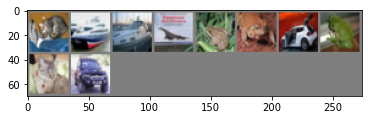

Real labels:    cat  ship  ship plane  frog  frog   car  frog   cat   car
Predicted:    cat  ship   car plane  frog truck   cat  bird   cat truck


In [36]:
if __name__ == "__main__":
    
    # Let's build our model
    train(5)
    print('Finished Training')

    # Test which classes performed well
    testAccuracy()
    
    # Let's load the model we just created and test the accuracy per label
    model = Network()
    path = "myFirstModel.pth"
    model.load_state_dict(torch.load(path))

    # Test with batch of images
    testBatch()

2와 같은 Epoch 수(학습 데이터 세트를 통과하는 전체 횟수)를 선택하면([train(2)]) 10,000개 이미지의 전체 테스트 데이터 세트를 두 번 반복합니다. 8세대 Intel CPU에 대한 학습을 완료하는 데 약 20분이 걸리며, 이 모델은 10개의 레이블 분류에서 거의 65%의 성공률을 달성합니다.

정의한 대로 손실 값은 1,000개의 이미지 일괄 처리마다 출력되거나 학습 세트를 반복할 떄마다 5번 출력됩니다. 모든 루프에서 손실 값이 감소해야 합니다.

또한 각 반복 후에 모델의 정확도를 확인할 수 있습니다. 모델 정확도는 손실 값과 다릅니다. 손실 함수를 통해 학습 세트에서 최적화를 반복할 때마다 모델이 얼마나 잘 작동하는지 이해할 수 있습니다. 모델의 정확도는 테스트 데이터에서 계산되며 올바른 예측의 백분율을 보여 줍니다. 여기서는 모델에서 각 학습을 반복한 후 10,000개의 이미지 테스트 세트에서 올바르게 분류할 수 있었던 이미지의 수를 알려줍니다.

In [37]:
# Function to test what classes performed well
def testClassess():
    class_correct = list(0. for i in range(number_of_labels))
    class_total = list(0. for i in range(number_of_labels))
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(batch_size):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(number_of_labels):
        print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [38]:
testClassess()

Accuracy of plane : 81 %
Accuracy of   car : 77 %
Accuracy of  bird : 44 %
Accuracy of   cat : 51 %
Accuracy of  deer : 53 %
Accuracy of   dog : 44 %
Accuracy of  frog : 46 %
Accuracy of horse : 72 %
Accuracy of  ship : 77 %
Accuracy of truck : 81 %
